In [1]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip install -q pydicom 
!pip install -q imgaug 
!pip install -q kaggle
!pip install -q tqdm 

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize
from keras import layers
import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt

c:\users\eric\anaconda2\envs\hse_dl\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {
      'name': name,
      'mimeType': 'application/octet-stream'
     }

    media = MediaFileUpload(path, 
                    mimetype='application/octet-stream',
                    resumable=True)

    created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created

In [0]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

In [5]:
!ls

adc.json  sample_data


In [6]:
# If you are unable to download the competition dataset, check to see if you have 
# accepted the user agreement on the competition website. 
!kaggle competitions download -c rsna-pneumonia-detection-challenge

  0%|                                                | 0.00/55.0 [00:00<?, ?B/s]
100%|████████████████████████████████████████| 55.0/55.0 [00:00<00:00, 29.1kB/s]
  0%|                                                | 0.00/561k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 561k/561k [00:00<00:00, 79.4MB/s]
  0%|                                               | 0.00/51.8k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 51.8k/51.8k [00:00<00:00, 33.9MB/s]
  0%|                                                | 0.00/634k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 634k/634k [00:00<00:00, 61.7MB/s]
 96%|██████████████████████████████████████▎ | 121M/126M [00:02<00:00, 51.5MB/s]
100%|████████████████████████████████████████| 126M/126M [00:02<00:00, 59.2MB/s]
100%|█████████████████████████████████████▉| 3.16G/3.17G [01:05<00:00, 56.7MB/s]
100%|██████████████████████████████████████| 3.17G/3.17G [01:05<00:00, 52.1MB/s]


In [0]:
# unzipping takes a few minutes
!unzip -q -o stage_1_test_images.zip -d stage_1_test_images
!unzip -q -o stage_1_train_images.zip -d stage_1_train_images
!unzip -q -o stage_1_train_labels.csv.zip

## Load Data

In [21]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [22]:
# empty dictionary
labels = {}
# load table
with open('./stage_1_train_labels.csv', mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        nodule = rows[5]
        
        labels[filename] = nodule

In [23]:
# load and shuffle filenames
folder = train_dicom_dir
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 0
n valid samples 530


## Create Model

In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = 384
CHECKPOINT_PATH = "model2.h5"

In [4]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, nodule_locations=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.nodule_locations = nodule_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains nodules
        if filename in nodule_locations:
            # get the location
            msk = nodule_locations[filename]
            # make sure it's the right length, if not right pad with 0s
            
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

## Create Network

In [17]:
def _conv(filters, inputs, layers=3):
    x = inputs
    for _ in range(layers):
        x = keras.layers.BatchNormalization(momentum=0.9)(x)
        x = keras.layers.LeakyReLU(0)(x)
        x = keras.layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    
    return x

def _downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_network(input_size, channels, n_blocks=2, depth=5):
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        if channels > 512:
            channels = 512
        
        x = _downsample(channels, x)
        for b in range(n_blocks):
            x = _conv(channels, x, layers=2)
        
    # downsample 
    x = _downsample(512, x)
    
    # reduce feature maps
    x = keras.layers.Conv2D(384, (1,1), strides=(1,1), padding='same', activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    # turn into 1x1x102
    x = keras.layers.Conv2D(768, (6,6), strides=(1,1), padding='valid', activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    # "fc" layer
    x = keras.layers.Conv2D(512, (1,1), strides=(1,1), padding='valid', activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    # output
    confidences = keras.layers.Conv2D(1, (1,1), strides=(1,1), padding='valid', activation="sigmoid")(x)
    
    model = keras.Model(inputs=inputs, outputs=confidences)
    return model

In [26]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def custom_loss(y_true, y_pred):
    xe_loss = calc_xe_loss(y_true, y_pred)
    mse_loss = calc_mse_loss(y_true, y_pred)
    
    return xe_loss + mse_loss

def calc_xe_loss(y_true, y_pred):
    # separate out our boxes
    box1_pred = y_pred[:,:5]
    box2_pred = y_pred[:,5:]
    
    box1_true = y_true[:,:5]
    box2_true = y_true[:,5:]
    
    # cross entropy on confidences for both boxes
    xe_loss_1 = keras.losses.binary_crossentropy(box1_true[:,0], box1_pred[:,0])
    xe_loss_2 = keras.losses.binary_crossentropy(box2_true[:,0], box2_pred[:,0])
    
    return (0.4 * xe_loss_1) + (0.4 * xe_loss_2)

def calc_mse_loss(y_true, y_pred):
    # separate out our boxes
    box1_pred = y_pred[:,:5]
    box2_pred = y_pred[:,5:]
    
    box1_true = y_true[:,:5]
    box2_true = y_true[:,5:]
    
    # compare the predictions to the truth
    mse_loss_1 = keras.losses.mean_squared_error(box1_true[:,1:], box1_pred[:,1:])
    mse_loss_2 = keras.losses.mean_squared_error(box2_true[:,1:], box2_pred[:,1:])    
    
    # if we have truth compare the predictions to the opposite boxes, otherwise use the existing loss
    if box1_true[:,3] != 0:
        mse_loss_3 = keras.losses.mean_squared_error(box1_true[:,1:], box2_pred[:,1:])
    else:
        mse_loss_3 = mse_loss_1
      
    if box2_true[:,3] != 0:
        mse_loss_4 = keras.losses.mean_squared_error(box2_true[:,1:], box1_pred[:,1:])
    else:
        mse_loss_4 = mse_loss_2
      
    # average the mses and divide to keep it in line with cross entropy
    return ((0.25 * mse_loss_1) + (0.25 * mse_loss_2) + (0.25 * mse_loss_3) + (0.25 * mse_loss_4)) / 10000

# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=24, n_blocks=2, depth=5)
print(model.summary())

model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.003
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
  
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
checkpoint = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)


# create train and validation generators
folder = train_dicom_dir
train_gen = generator(folder, train_filenames, labels, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, predict=False)
valid_gen = generator(folder, valid_filenames, labels, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 384, 384, 1)       0         
_________________________________________________________________
conv2d_305 (Conv2D)          (None, 384, 384, 24)      216       
_________________________________________________________________
batch_normalization_289 (Bat (None, 384, 384, 24)      96        
_________________________________________________________________
leaky_re_lu_289 (LeakyReLU)  (None, 384, 384, 24)      0         
_________________________________________________________________
conv2d_306 (Conv2D)          (None, 384, 384, 48)      1152      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 192, 192, 48)      0         
_________________________________________________________________
batch_normalization_290 (Bat (None, 192, 192, 48)      192       
__________

In [69]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=5, shuffle=True, verbose=1)

Epoch 1/5
1927/1927 [==============================] - 1567s 813ms/step - loss: 3.7830 - acc: 0.0509 - calc_xe_loss: 1.8038 - calc_mse_loss: 1.9792 - val_loss: 3.0141 - val_acc: 0.0481 - val_calc_xe_loss: 1.0282 - val_calc_mse_loss: 1.9859
Epoch 2/5
1927/1927 [==============================] - 1542s 800ms/step - loss: 2.9695 - acc: 0.0532 - calc_xe_loss: 1.0012 - calc_mse_loss: 1.9683 - val_loss: 2.9105 - val_acc: 0.0513 - val_calc_xe_loss: 1.0194 - val_calc_mse_loss: 1.8911
Epoch 3/5
1927/1927 [==============================] - 1542s 800ms/step - loss: 2.8423 - acc: 0.0520 - calc_xe_loss: 0.9853 - calc_mse_loss: 1.8570 - val_loss: 2.8604 - val_acc: 0.0520 - val_calc_xe_loss: 1.0205 - val_calc_mse_loss: 1.8399
Epoch 4/5
1927/1927 [==============================] - 1540s 799ms/step - loss: 2.8190 - acc: 0.0533 - calc_xe_loss: 0.9846 - calc_mse_loss: 1.8344 - val_loss: 2.8412 - val_acc: 0.0485 - val_calc_xe_loss: 1.0139 - val_calc_mse_loss: 1.8274
Epoch 5/5
1927/1927 [===================

In [0]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=5, shuffle=True, verbose=1)

Epoch 1/5
 483/1927 [======>.......................] - ETA: 18:12 - loss: 2.8490 - acc: 0.0557 - calc_xe_loss: 0.9920 - calc_mse_loss: 1.8570

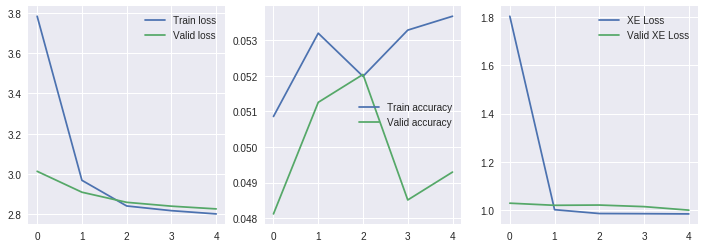

In [72]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["calc_xe_loss"], label="XE Loss")
plt.plot(history.epoch, history.history["val_calc_xe_loss"], label="Valid XE Loss")
plt.legend()
plt.show()

In [95]:
# load and shuffle filenames
folder = test_dicom_dir
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))
THRESHOLD = 0.2
TEST_BATCH_SIZE = 32

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=TEST_BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=True)

submission_dict = {}

# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    
    for pred, filename in zip(preds, filenames):
      
        # make sure they are all greater than or equal to 0
        for i in range(len(pred)):
            if pred[i] < 0:
                pred[i] = 0
          
        # make all values other than confidence ints
        if i is not 1 and i is not 5:
            pred[i] = int(pred[i])
      
        # separate out our boxes
        pred_box_1 = pred[:5]
        pred_box_2 = pred[5:]
        #       print("1:", pred_box_1)
        #       print("2:", pred_box_2)

        # initialize our string
        predictionString = ""
      
        # if we have a prediction for box 1 turn it into a string
        if pred_box_1[0] > THRESHOLD:
            predictionString = " ".join(str(x) for x in pred_box_1)
        
        # if we have a prediction for box 2 turn it into a string and append it to our existing string        
        if pred_box_2[0]  > THRESHOLD:
            predString_2 = " ".join(str(x) for x in pred_box_2)
            predictionString += predString2

        #       print(predictionString)

        # remove the extension from the filename
        filename = filename.split('.')[0]
        # add the prediction to the dictionary
        submission_dict[filename] = predictionString

        # stop if we've got them all
        if len(submission_dict) >= len(test_filenames):
            break

print("Done Predicting!")  
  
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')     

n test samples: 1000
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(32, 384, 384, 1)
(8, 384, 384, 1)
Done Predicting!


In [96]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f submission.csv -m "Colab YOLO size 384x384 take 1"

Successfully submitted to RSNA Pneumonia Detection Challenge

In [89]:
save_file_to_drive("submission.csv", "submission.csv")
# save_file_to_drive(CHECKPOINT_PATH, CHECKPOINT_PATH)

File ID: 1UMGDvYUVDs1FmK1n8U4SH7r0bHNLs2o_


{'id': '1UMGDvYUVDs1FmK1n8U4SH7r0bHNLs2o_'}